In [166]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/airport.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [167]:
with open('../input/passenger-dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air-passengers.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826402 entries, 0 to 1826401
Data columns (total 52 columns):
ANumber                         category
LastName                        category
FirstName                       category
DOB                             category
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  

In [168]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [169]:
df.tail()

,ANumber,LastName,FirstName,DOB,Status,Sex,Convictions,GangMember,ClassLvl,Age,...,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,NonCriminal
1826397,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,20.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826398,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,34.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826399,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,19.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826400,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,33.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826401,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8C,F,NC,N,NaN,24.0,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,True


# Specific airport

In [170]:
# Select records for an airport represented in the database using its 4-character ICAO code
airport = 'KBFI'
airport = str(airport).upper()

In [171]:
airport_name = airport_dict[airport]['AirportName']

# Creating DataFrames for pickup and dropoff records.
# If memory usage is too great these can be deleted and assigned again as needed.
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport
pickup_df = df[pickup].copy()
dropoff_df = df[dropoff].copy()

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# DataFrame for all records relating to selected airport.
all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# DataFrames for all records categorized as removals, transfers.
removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal].copy()
transfer_df = all_df[transfer].copy()

# Names here are used downstream in figure labels.
all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Departures'
dropoff_df.name = 'Arrivals'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].count()

# Resampled counts of passengers and missions for different timeframes and types of record.
weekly_pickups = pickup_df['AlienMasterID'].resample('W').count()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').count()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').count()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').count()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').count()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').count()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').count()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').count()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').count()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
annual_total_missions = all_df['MissionID'].resample('AS-OCT').nunique()

# Various descriptive statistics for selected airport
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = unique_removals / total_unique * 100
transfer_percent = unique_transfers / total_unique * 100
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

KeyError: 'KBIF'

In [80]:
total_unique

52514

In [81]:
annual_total

MissionDate
2010-10-01    7181
2011-10-01    6839
2012-10-01    6950
2013-10-01    6202
2014-10-01    4658
2015-10-01    5866
2016-10-01    4877
2017-10-01    5999
2018-10-01    3942
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [82]:
# Top destination airports for removals from selected airport
pickup_df[pickup_df['R-T'] == 'R']['air2_AirportName'].value_counts().head(10)

San Diego International Airport                         9588
Valley International Airport                            3128
El Paso International Airport                           2301
Phoenix-Mesa-Gateway Airport                            1425
El Centro Naf Airport                                    174
La Aurora Airport                                        114
El Salvador International Airport                         97
San Antonio International Airport                         26
Yuma MCAS/Yuma International Airport                      23
Brownsville South Padre Island International Airport      17
Name: air2_AirportName, dtype: int64

In [83]:
# Top destination airports for transfers from selected airport
pickup_df[pickup_df['R-T'] == 'T']['air2_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                            9251
El Paso International Airport                           9230
Alexandria International Airport                         383
San Antonio International Airport                        107
San Diego International Airport                           64
Brownsville South Padre Island International Airport      55
Meadows Field                                             23
George Bush Intercontinental Houston Airport              21
Valley International Airport                              11
McCarran International Airport                             2
Name: air2_AirportName, dtype: int64

In [84]:
missions_df = all_missions.reset_index()
missions_df = missions_df.rename({"AlienMasterID": "Passengers"}, axis=1)

In [85]:
missions_df.to_csv(f'../output/{airport}_missions.csv', index=False)

In [86]:
missions_df

,MissionDate,MissionID,PULOC,DropLoc,Passengers
0,2010-10-02,137,KBFI,KIWA,1
1,2010-10-02,137,KBFI,KSAN,53
2,2010-10-02,137,KIWA,KBFI,26
3,2010-10-06,117,KBFI,KHRL,18
4,2010-10-06,117,KBFI,KIWA,28
5,2010-10-06,117,KIWA,KBFI,1
6,2010-10-09,128,KBFI,KSAN,63
7,2010-10-09,128,KIWA,KBFI,17
8,2010-10-13,172,KBFI,KHRL,27
9,2010-10-13,172,KBFI,KIAH,21


# Annual trends (by fiscal year)

In [87]:
fy_index = pd.date_range(start='2010-10-01', end='2019-01-01', freq='AS-OCT')

In [88]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True)
annual_total_missions.rename('Total missions', inplace=True)

MissionDate
2010-10-01    101
2011-10-01     76
2012-10-01     61
2013-10-01     63
2014-10-01     39
2015-10-01     50
2016-10-01     59
2017-10-01     55
2018-10-01     32
Freq: AS-OCT, Name: Total missions, dtype: int64

In [89]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
              'Annual Dropoff Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total Passengers': annual_total,
              'Annual Total Missions': annual_total_missions}, index=fy_index)

In [90]:
annual_total_missions

MissionDate
2010-10-01    101
2011-10-01     76
2012-10-01     61
2013-10-01     63
2014-10-01     39
2015-10-01     50
2016-10-01     59
2017-10-01     55
2018-10-01     32
Freq: AS-OCT, Name: Total missions, dtype: int64

In [91]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

In [92]:
annual_summary

,Annual Pickups,Annual Pickup Missions,Annual Dropoffs,Annual Dropoff Missions,Annual Removals,Annual Transfers,Annual Total Passengers,Annual Total Missions
Fiscal Year,,,,,,,,
2011,6629,99,552,47,5815,1366,7181,101
2012,5664,70,1175,51,4638,2201,6839,76
2013,4797,50,2153,44,2460,4490,6950,61
2014,3955,51,2247,48,685,5517,6202,63
2015,2732,33,1926,37,313,4345,4658,39
2016,3129,47,2737,44,225,5641,5866,50
2017,3390,53,1487,42,406,4471,4877,59
2018,3495,53,2504,50,1075,4924,5999,55
2019,2257,32,1685,26,1311,2631,3942,32


In [93]:
flat_summary = annual_summary.unstack().to_frame().T 

In [94]:
flat_summary.index = [airport]

In [95]:
flat_summary.columns = flat_summary.columns.tolist()

In [96]:
# annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [97]:
# annual_dropoffs.to_csv('../output/KBFI-dropoffs.csv')

In [98]:
def bar_chart(data, airport=str, airport_name=str, filename=str, title=str):
    fig, ax = plt.subplots()

    data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              rot=0,
              grid=True,
              figsize=(8,6),
              fontsize=14)
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{title}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    plt.figtext(0.7, .02, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
#     fig.savefig(f'../output/{airport}_{filename}.png')
    plt.show()
    plt.close()

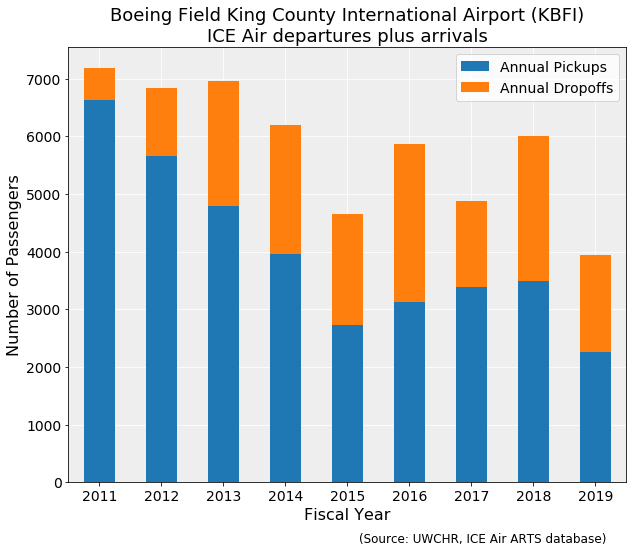

In [99]:
data = annual_summary[['Annual Pickups', 'Annual Dropoffs']]
title = f'{airport_name} ({airport})\nICE Air departures plus arrivals'
bar_chart(data, airport, airport_name, 'pickup-dropoff', title)
plt.show()

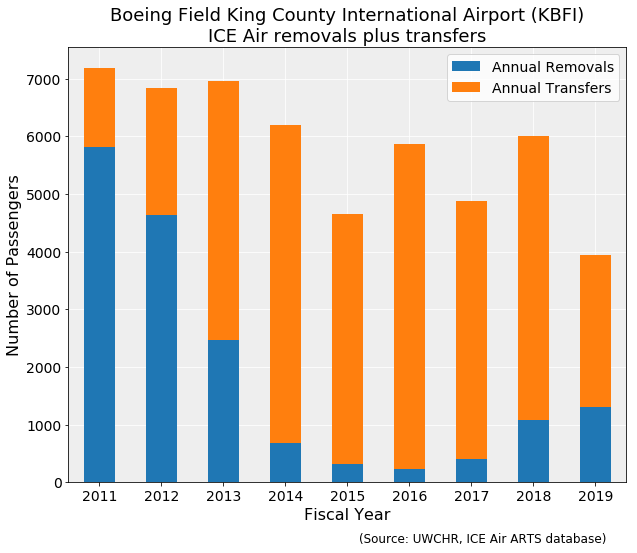

In [100]:
data = annual_summary[['Annual Removals', 'Annual Transfers']]
title = f'{airport_name} ({airport})\nICE Air removals plus transfers'
bar_chart(data, airport, airport_name, 'removal-transfer', title)
plt.show()

In [101]:
annual_summary[['Annual Pickups', 'Annual Dropoffs']].to_csv(f'../output/{airport}-AnnualDeparturesArrivals.csv')

In [102]:
# all_df.to_csv(f'../output/{airport}-allpassengers.csv')

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [103]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [104]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

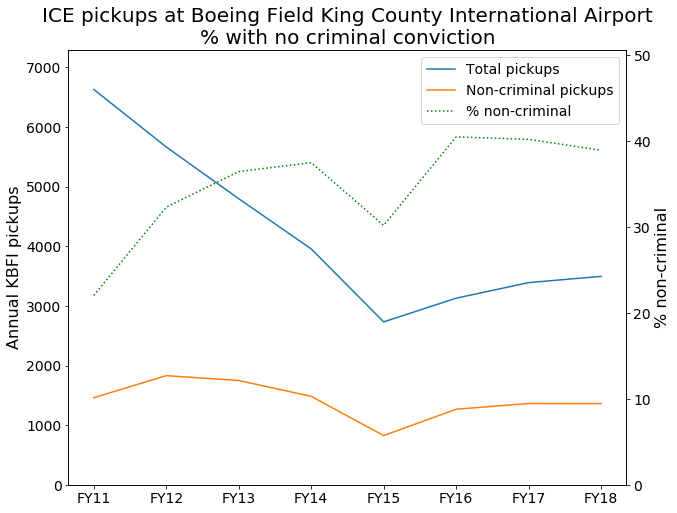

In [105]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

# plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.grid(None)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(None)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by FY)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

In [106]:
monthly_means = pd.DataFrame()
for year in range(2011, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [107]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2011,4.42,59.00,8.33,544.17
2012,3.92,115.42,4.83,450.17
2013,3.17,165.25,4.08,383.58
2014,3.83,161.92,3.92,300.00
2015,3.17,209.00,2.83,237.67
2016,4.17,231.50,4.50,264.83
2017,3.50,120.92,4.25,288.50
2018,3.92,208.83,4.42,293.67


In [108]:
# monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [109]:
removal_df[removal_df['CountryOfCitizenship'] == 'EL SALVADOR']['DropLoc']

MissionDate
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
              ... 
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP
2014-06-02    MSLP


In [110]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                26049
GUATEMALA              3681
EL SALVADOR            2741
HONDURAS               2264
HAITI                   462
ECUADOR                 178
NICARAGUA               130
CAMBODIA                119
COLOMBIA                 54
DOMINICAN REPUBLIC       36
Name: CountryOfCitizenship, dtype: int64

In [111]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR    3527
GUATEMALA      2854
MEXICO         2388
HONDURAS       2070
INDIA          1643
Name: CountryOfCitizenship, dtype: int64

In [112]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         28437
GUATEMALA       6535
EL SALVADOR     6268
HONDURAS        4334
INDIA           1675
Name: CountryOfCitizenship, dtype: int64

In [113]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [114]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [115]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [116]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [117]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = pickup_df.copy()
df_to_analyze.name = pickup_df.name

In [118]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [119]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [120]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [121]:
all_passenger_nationality_by_year.loc['2016':'2017'].T.dropna(how='all').to_csv('../output/kbfi_pickups_by_nationality.csv')

In [122]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [123]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    txt=plt.figtext(0.7, -0.00, txt, wrap=True, horizontalalignment='center', fontsize=12)
    lgd=plt.legend(fontsize=12)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_extra_artists=(lgd,txt), bbox_inches='tight')
    return fig, ax

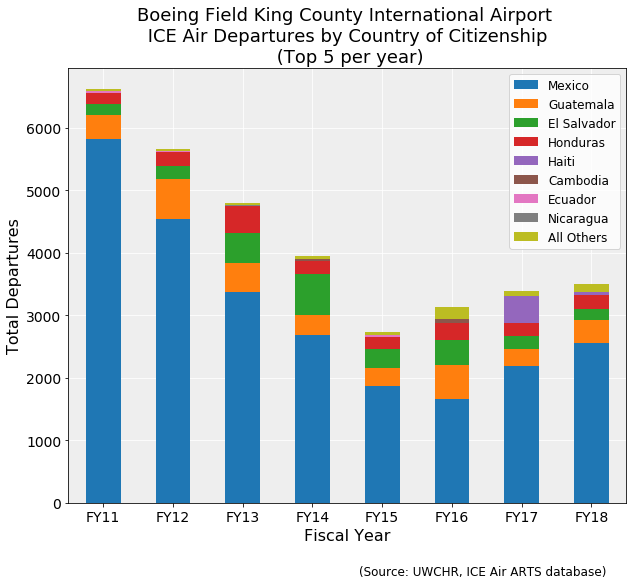

In [124]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [125]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary number of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [126]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [127]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)
annual = annual['2010':'2017']

In [128]:
# Select arbitrary number of top values to display here
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

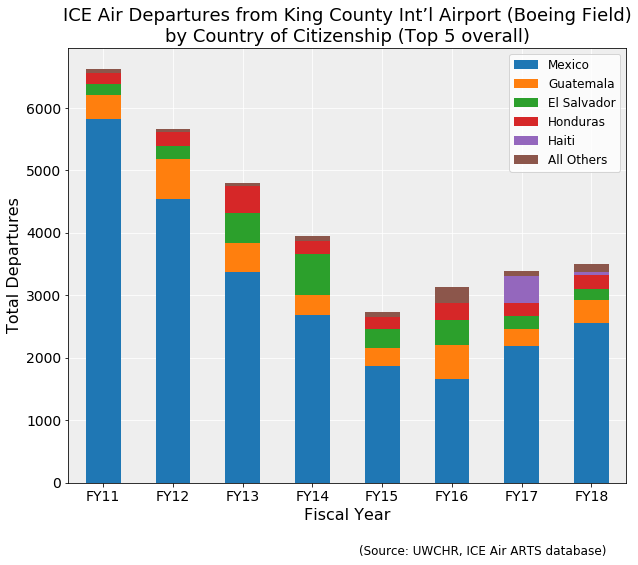

In [129]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air Departures from King County Int’l Airport (Boeing Field)\nby Country of Citizenship (Top 5 overall)',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Not top nationalities

In [130]:
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

not_top_df = pd.DataFrame()
not_top_df = not_top_df.append(annual[~annual['CountryOfCitizenship'].isin(top)])
not_top_df.index = not_top_df.index.year

In [131]:
not_top_data = pd.pivot_table(data=not_top_df,
                       index=not_top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
not_top_data = not_top_data.reindex(not_top_data.sum().sort_values(ascending=False).index, axis=1)
# cols = list(not_top_data.columns)
# cols.remove('ALL OTHERS')
# cols.append('ALL OTHERS')
# not_top_data = not_top_data[cols]
# not_top_data.columns = not_top_data.columns.astype(str)
# not_top_data.columns = not_top_data.columns.str.title()

In [132]:
not_top_data.sum().head(15)

CountryOfCitizenship
ECUADOR               169
NICARAGUA             113
CAMBODIA              109
COLOMBIA               49
DOMINICAN REPUBLIC     33
INDIA                  30
SOMALIA                27
GUINEA                 26
ERITREA                18
MOLDOVA                15
JAMAICA                14
CHINA                  14
GHANA                  13
UKRAINE                13
VIETNAM                 8
dtype: int64

In [133]:
all_others = not_top_data.sum()[not_top_data.sum() < 50].index
greater_than_x = not_top_data.sum()[not_top_data.sum() > 50].index
to_plot = not_top_data[greater_than_x].copy()
to_plot.columns = to_plot.columns.astype(str)
to_plot['ALL OTHERS'] = not_top_data[all_others].sum(axis=1)

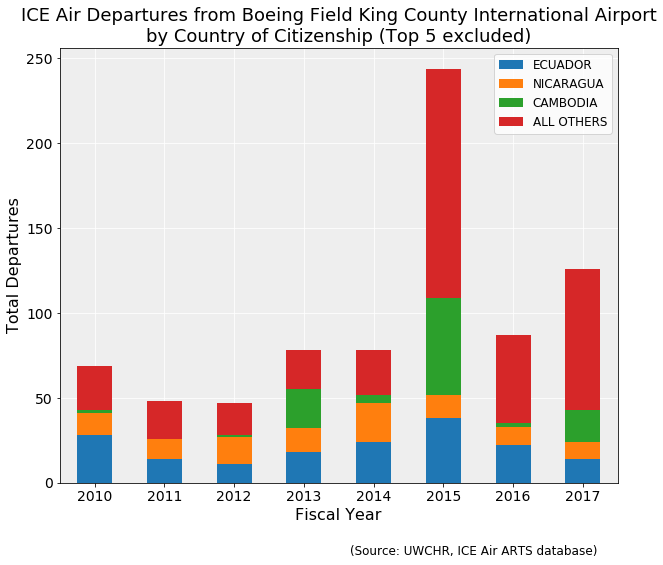

In [134]:
country_of_citizenship_trend(to_plot,
                             title=f'ICE Air Departures from {airport_name}\nby Country of Citizenship (Top 5 excluded)',
                             filename=f'{airport}_pickup_nationalities_top_5_excluded',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [135]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [136]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile            False  True   percent
PULOC MissionDate                        
KBFI  2010-10-01   6613.0  16.0  0.241948
      2011-10-01   5653.0  11.0  0.194587
      2012-10-01   4795.0   2.0  0.041710
      2013-10-01   3953.0   2.0  0.050594
      2014-10-01   2732.0   NaN       NaN
      2015-10-01   3129.0   NaN       NaN
      2016-10-01   3381.0   9.0  0.266193
      2017-10-01   3490.0   5.0  0.143266
      2018-10-01   2253.0   4.0  0.177541

In [137]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [138]:
juvenile_pickups

Juvenile              False  True 
DropLoc MissionDate               
KBFI    2010-10-01    550.0    2.0
        2011-10-01   1172.0    3.0
        2012-10-01   2151.0    2.0
        2013-10-01   2177.0   70.0
        2014-10-01   1926.0    NaN
        2015-10-01   2737.0    NaN
        2016-10-01   1487.0    NaN
        2017-10-01   2504.0    NaN
        2018-10-01   1685.0    NaN

In [139]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile              False  True   percent
DropLoc MissionDate                        
KBFI    2010-10-01    550.0   2.0  0.363636
        2011-10-01   1172.0   3.0  0.255973
        2012-10-01   2151.0   2.0  0.092980
        2013-10-01   2177.0  70.0  3.215434
        2014-10-01   1926.0   NaN       NaN
        2015-10-01   2737.0   NaN       NaN
        2016-10-01   1487.0   NaN       NaN
        2017-10-01   2504.0   NaN       NaN
        2018-10-01   1685.0   NaN       NaN

In [140]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [141]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

Juvenile          False  True 
R-T MissionDate               
R   2010-10-01   5802.0   13.0
    2011-10-01   4629.0    9.0
    2012-10-01   2458.0    2.0
    2013-10-01    685.0    NaN
    2014-10-01    313.0    NaN
    2015-10-01    225.0    NaN
    2016-10-01    406.0    NaN
    2017-10-01   1071.0    4.0
    2018-10-01   1311.0    NaN
T   2010-10-01   1361.0    5.0
    2011-10-01   2196.0    5.0
    2012-10-01   4488.0    2.0
    2013-10-01   5445.0   72.0
    2014-10-01   4345.0    NaN
    2015-10-01   5641.0    NaN
    2016-10-01   4462.0    9.0
    2017-10-01   4923.0    1.0
    2018-10-01   2627.0    4.0

# Detainee status

In [142]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [143]:
status = pd.read_csv('../../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
problematic = pending + benefit + expedited_admin_rein

In [144]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')
print(f"{sum(removal_df['Status'].isin(pending))} with pending appeals.")
print(f"{sum(removal_df['Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(removal_df['Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.")

KBFI - Boeing Field King County International Airport

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

8387 valid values.
8541 invalid values.

[1A]: 2446 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 20 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *36* (Deportable – Under Adjudication by IJ)
[2B]: *1* (Deportable – Under Adjudication by BIA)
[3]: 229 (Deportable – Administratively Final Order)
[5A]: 1 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 20 (Removable – ICE Fugitive)
[5C]: *1* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *1* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 3 (Relief Granted – Extended Voluntary Departure)
[5F]: 0 (Unable to Obtain Travel Document)
[8A]: *42* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *10

In [145]:
sum(removal_df['Status'].isin(expedited_admin_rein))

2929

In [146]:
sum(removal_df['Status'].isin(pending))

198

In [147]:
sum(removal_df['Status'].isin(benefit))

2

In [148]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [149]:
total

MissionDate
2010-10-01    5815
2011-10-01    4638
2012-10-01    2460
2013-10-01     685
2014-10-01     313
2015-10-01     225
2016-10-01     406
2017-10-01    1075
2018-10-01    1311
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [150]:
transfer_status = transfer_df['Status'].value_counts()

In [151]:
transfer_status[transfer_status >= 100]

8G                8729
16                7454
8F                6161
8C                3885
TRANSFER - F/O    2082
11                1002
NO STATUS          935
8A                 814
3                  626
12                 577
ER-TRANSFER        367
2A                 357
REMOVAL            334
1A                 331
TRANSFER - NTA     243
8B                 243
NTA                207
8E                 158
9                  139
Name: Status, dtype: int64

In [152]:
pickup_transfer_status = pickup_df[pickup_df['R-T'] == 'T']['Status'].value_counts()

In [153]:
pickup_transfer_status[pickup_transfer_status > 100]

16                5224
8C                3801
8F                2434
TRANSFER - F/O    1927
8G                1610
11                 992
12                 577
3                  501
1A                 328
REMOVAL            309
2A                 303
8B                 215
NO STATUS          153
8E                 151
9                  137
Name: Status, dtype: int64

In [154]:
dropoff_status = dropoff_df['Status'].value_counts()
dropoff_status[dropoff_status > 1]

8G                  7138
8F                  3732
16                  2232
NO STATUS            782
8A                   735
ER-TRANSFER          367
TRANSFER - NTA       221
NTA                  207
TRANSFER - F/O       155
3                    125
TRANSFER-NTA          98
TRANSFER              95
8C                    84
REINSTATE             61
NTA-TRANSFER          59
2A                    54
NTA-NEW               32
8B                    28
REMOVAL               25
X-NTA                 16
1/15/1900             14
8D                    13
5F                    12
10                    11
RF                    11
TRANSFER/SEA          10
T-NTA                 10
11                    10
ER-NEW                 9
TRANSFER -             9
RM                     7
8E                     7
2B                     7
ER/CRE.FR.             6
WA/NTA                 5
5B                     4
RR-TRANSFER            4
TRAN-NTA               4
BIA PEND               3
ER-TTRANSFER           3


## Finding most common day of week

In [155]:
all_df['MissionWeekday'] = all_df.index.weekday

In [156]:
index = range(0,7)

In [157]:
weekdays_2018 = all_df.loc['2018'].groupby(['MissionWeekday'])['MissionID'].nunique()

In [158]:
weekdays_2018 = weekdays_2018.reset_index()

In [159]:
weekdays_2018 = weekdays_2018.set_index('MissionWeekday')

In [160]:
weekdays_2018 = weekdays_2018.reindex(index=index)

In [161]:
weekdays_2018 = weekdays_2018.rename({'MissionID': 'Flights'}, axis=1)

In [162]:
weekdays_2018 = weekdays_2018.T
weekdays_2018.columns = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

In [163]:
weekdays_2018.fillna(0, inplace=True)

In [164]:
weekdays_2018

,M,Tu,W,Th,F,Sa,Su
Flights,1.0,49.0,1.0,0.0,1.0,1.0,2.0


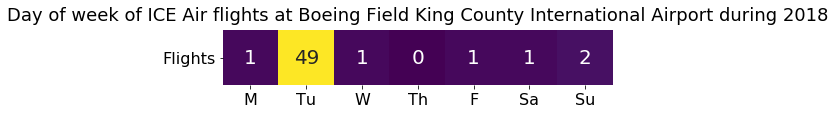

In [165]:
fig, ax = plt.subplots()
fig.set_size_inches(7,1)
ax = sns.heatmap(weekdays_2018, annot=True, annot_kws={"size": 20}, fmt='.0f', cmap=plt.cm.viridis, cbar=False)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, rotation=0)
# ax.set_ylabel('Year', fontsize=14)
# ax.set_xlabel('Weekday', fontsize=14)
ax.set_title(f'Day of week of ICE Air flights at {airport_name} during 2018', fontsize=18, pad=10);
# fig.savefig(f'../output/{airport}-weekdays.png', dpi=100,  bbox_inches='tight')